In [3]:
from transformers import MarianMTModel, MarianTokenizer

name_model = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = MarianTokenizer.from_pretrained(name_model)
test_text = "Hey, how is your college going?"
tokens = tokenizer(test_text, return_tensors = "pt")
print(tokens)

{'input_ids': tensor([[ 5312,     2,   287,    23,    85, 15550,  1098,    22,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


/home/vedant/.local/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


It is visible that the input sentance has been converted to the input token vector and also an attention mask has been returned 
that is showing us to which tokens the self attention will be distributing attention. For Tokens that are used for the means of padding for 
example, the attention mask will be set to 0, instructing the transformer to not give those tokens any attention in the search of better versions 
of the embeddings

In [9]:
model = MarianMTModel.from_pretrained(name_model)


In [10]:
#tersting the preloaded model's working with the means of initialised weights from pre-training.
text = "I am on my way to classes for today morning"
tokens = tokenizer(text, return_tensors = "pt")
translated_tokens = model.generate(**tokens)
translation = tokenizer.decode(translated_tokens[0], skip_special_tokens= True)
print("This below is the translated version of the english sentance in hindi\n")
print(translation)

This below is the translated version of the english sentance in hindi

मैं आज सुबह के लिए क्लासों के लिए जा रहा हूँ


In [36]:
new_text = ["Hey, how is it going for you","How has your day been today?"]
tokens = tokenizer(new_text, return_tensors = "pt", padding = True)
print(tokens)

{'input_ids': tensor([[ 5312,     2,   287,    23,    52,  1098,    34,    27,     0],
        [  244,   120,    85,   243,   203,   765,    22,     0, 61949]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]])}


In [37]:
output_tokens = model.generate(**tokens)
for i in output_tokens:
    print(tokenizer.decode(i,skip_special_tokens = True))

अरे, यह आप के लिए कैसे जा रहा है
आज आपका दिन कैसा रहा है?


In [3]:
from datasets import load_dataset

dataset = load_dataset("cfilt/iitb-english-hindi")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})


We see above that the dataset is already partitioned into the desired train validation and test splits, which means we can go
ahead and tokenize the input data and also do padding to keep the tensor dimensions to be uniform.

In [4]:
from tqdm import tqdm

def token_padding(examples, progress_bar=None):
    source_text = [item["en"] for item in examples["translation"]]
    target_text = [item["hi"] for item in examples["translation"]]
    inputs = tokenizer_b(source_text, truncation= True,padding= "max_length", max_length= 128)
    targets = tokenizer_b(target_text, truncation = True, padding = "max_length" ,max_length = 128)
    if progress_bar is not None:
        progress_bar.update(len(source_text))

    return {"input_ids":inputs["input_ids"],"attention_mask":inputs["attention_mask"],"labels":targets["input_ids"],}

tot_samples = len(dataset)
print(f"The total number of samples is {tot_samples}")

with tqdm(total = tot_samples,desc = "Tokenizing dataset") as progress_bar:
    tokenized_datasets = dataset.map(
        lambda examples: token_padding(examples, progress_bar),
        batched=True, 
        batch_size=512,
        num_proc=4, 
        desc="Tokenizing Dataset"
    )
tokenized_ds = tokenized_datasets.with_format("torch", device = "cuda")

The total number of samples is 3


Tokenizing dataset:   0%|                                                                         | 0/3 [00:00<?, ?it/s]

Tokenizing Dataset (num_proc=4):   0%|          | 0/1659083 [00:00<?, ? examples/s]

Tokenizing dataset: 414720it [01:33, 4627.81it/s]]                                                                      

Tokenizing Dataset (num_proc=4):   0%|          | 0/520 [00:00<?, ? examples/s]

Tokenizing dataset: 130it [01:34,  1.38it/s]                                                                            

Tokenizing Dataset (num_proc=4):   0%|          | 0/2507 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|                                                                         | 0/3 [01:34<?, ?it/s]


In [48]:
print(tokenized_datasets)
print(tokenized_datasets["train"][0])  # Print first sample from training set


DatasetDict({
    train: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2507
    })
})
{'translation': {'en': 'Give your application an accessibility workout', 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}, 'input_ids': [3872, 85, 2501, 132, 15441, 36398, 0, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 

In [49]:
input_ids = tokenized_datasets["train"][0]["input_ids"]
decoded = tokenizer.decode(input_ids, skip_special_tokens = True)
print("Decoded :", decoded)

Decoded : Give your application an accessibility workout


In [50]:
print(len(tokenized_datasets["train"][0]["input_ids"]))  # Should match max_length (e.g., 128)
print(len(tokenized_datasets["train"][0]["labels"]))  # Should match max_length (e.g., 128)


128
128


So, looks liek the tokenization happened properly and the padding was also successful.

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import DatasetDict
from evaluate import load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

data_collator = DataCollatorForSeq2Seq(tokenizer,model= model)
bleu = load("bleu")
rouge= load("rouge")
meteor = load("meteor")

def find_metrics(eval_pred):
    predictions , labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens = True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens = True)
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in labels])["bleu"]
    rouge_score = rouge.compute(predictions=predictions, references=labels)["rougeL"]
    meteor_score = meteor.compute(predictions=predictions, references=labels)["meteor"]

    ret_dict = {"bleu": bleu_score, "rougeL": rouge_score, "meteor": meteor_score}
    return ret_dict

hpams = { "batch_size": 16,  "learning_rate": 3e-5, "epochs": 2 }
#these hpams can be tuned to:
'''batch_size : 8,16,32
    lr: 1e-4, 3e-5,5e-5
    epochs: 5, 10,15'''

training_args = Seq2SeqTrainingArguments(
    output_dir = "./results", evaluation_strategy = "steps",eval_steps = 10000, save_strategy= "steps", per_device_train_batch_size= hpams["batch_size"],
    per_device_eval_batch_size=hpams["batch_size"],learning_rate = hpams["learning_rate"],num_train_epochs= hpams["epochs"], 
    weight_decay=0.01,logging_dir="./logs",save_total_limit=3,predict_with_generate=True,
    fp16=torch.cuda.is_available(), 
    report_to="none")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=find_metrics
)

print("Trainingggg")
train_result = trainer.train()




[nltk_data] Downloading package wordnet to /home/vedant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vedant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vedant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/home/vedant/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_3614946/791313164.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Trainingggg


Step,Training Loss,Validation Loss,Bleu,Rougel,Meteor
10000,0.179900,0.511884,0.149481,0.096111,0.385513
20000,0.182400,0.518132,0.150553,0.091058,0.386553
30000,0.191200,0.510200,0.153834,0.088575,0.393200
40000,0.190600,0.497636,0.153723,0.093077,0.387780
50000,0.187200,0.497527,0.155640,0.098200,0.392698
60000,0.192200,0.499278,0.157028,0.092719,0.395540
70000,0.199300,0.492236,0.151364,0.092697,0.391488
80000,0.194000,0.484341,0.151807,0.089390,0.386571
90000,0.195000,0.489219,0.153796,0.094840,0.389429
100000,0.201200,0.477844,0.160295,0.091468,0.397617


AttributeError: type object 'Trainer' has no attribute 'get_last_checkpoint'

In [77]:
from transformers.trainer_utils import get_last_checkpoint
latest_checkpoint = get_last_checkpoint("./results")

if latest_checkpoint:
    print(f"Loading checkpoint: {latest_checkpoint}")
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("No checkpoint found, proceeding with evaluation.")

print("Evaluating on the test set...")
metrics = trainer.predict(tokenized_datasets["test"]).metrics
print(f"Evaluation Metrics: {metrics}")

model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


Loading checkpoint: ./results/checkpoint-207386


/home/vedant/.local/lib/python3.11/site-packages/transformers/trainer.py:3443: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NA

Step,Training Loss,Validation Loss


Evaluating on the test set...


Evaluation Metrics: {'test_loss': 0.501838743686676, 'test_bleu': 0.16646087246384608, 'test_rougeL': 0.14264635474867518, 'test_meteor': 0.4042937748151691, 'test_runtime': 104.3784, 'test_samples_per_second': 24.018, 'test_steps_per_second': 1.504}


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/source.spm',
 './fine_tuned_model/target.spm',
 './fine_tuned_model/added_tokens.json')

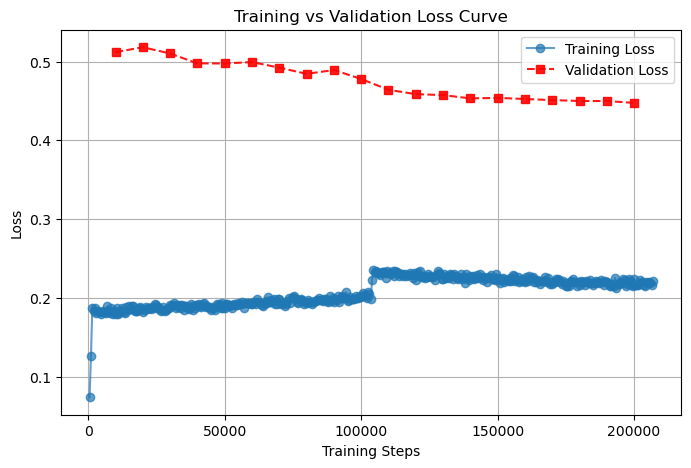

In [84]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
train_steps = [log["step"] for log in log_history if "loss" in log]
train_loss = [log["loss"] for log in log_history if "loss" in log]

eval_steps =[log["step"] for log in log_history if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label="Training Loss", marker="o", linestyle="-", alpha=0.7)
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="s", linestyle="--", alpha=0.9, color="red")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [85]:
def generate_translation(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    output_ids = model.generate(**inputs)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

sample_texts = [
    "Hello, how are you?",
    "I have fine tuned this model for the means of english-hindi translation",
    "This should be a much better model"
]

for text in tqdm(sample_texts, desc="Generating Translations"):
    before = generate_translation(text, model, tokenizer)
    print(f"**English:** {text}")
    print(f"**Hindi (Translated):** {before}\n")

Generating Translations:  33%|██████▋             | 1/3 [00:00<00:00,  8.42it/s]

**English:** Hello, how are you?
**Hindi (Translated):** नमस्ते, तुम कैसे हो?



Generating Translations: 100%|████████████████████| 3/3 [00:00<00:00,  5.73it/s]

**English:** I have fine tuned this model for the means of english-hindi translation
**Hindi (Translated):** मैंने अंग्रेजी-ंदी अनाद के साधनों के लिए इस मॉडल को ्छा बनाया

**English:** This should be a much better model
**Hindi (Translated):** यह एक बर मॉडल होना चाए



In [5]:
from transformers import MarianMTModel, MarianTokenizer
import torch
model_2 = "Helsinki-NLP/opus-mt-en-hi" 
tokenizer_b = MarianTokenizer.from_pretrained(model_2)
model_b = MarianMTModel.from_pretrained(model_2)

/home/vedant/.local/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [21]:
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b.to(device) 

def gen_translations(dataset):
    inputs = [ex["en"] for ex in dataset["translation"]]
    translations = []

    for i in tqdm(range(0, len(inputs), 16), desc="Generating Translations", unit="batch"):
        batch_inputs = inputs[i:i+16]  
        ips = tokenizer_b(batch_inputs, return_tensors="pt", padding=True, truncation=True)
        ips = {k: v.to(device) for k, v in ips.items()}
        ops = model_b.generate(**ips).to("cpu")
        batch_translations = tokenizer_b.batch_decode(ops, skip_special_tokens=True)
        translations.extend(batch_translations)
    return translations


small_sample = tokenized_datasets["test"].select(range(5))
try:
    preds = gen_translations(small_sample)  # Test on a small dataset
    references = tokenizer_b.batch_decode(small_sample["labels"], skip_special_tokens=True)
except Exception as e:
    print("🚨 Error detected:", e)
    print("Sample `labels` data:", small_sample["labels"][:5])
    exit()

preds = gen_translations(tokenized_datasets["test"])
references = tokenized_datasets["test"]["labels"]
metrics = find_metrics((preds, references))
print("These are the metrics for the pretrained model only\n", metrics)


Generating Translations: 100%|█████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.22batch/s]


These are the metrics for the pretrained model only
 {'bleu': 0.0690320505405765, 'rougeL': 0.10715301296673455, 'meteor': 0.25946561147935365}


In [20]:
from evaluate import load
bleu = load("bleu")
rouge= load("rouge")
meteor = load("meteor")
def find_metrics(eval_pred):
    predictions, labels = eval_pred 
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [[token for token in label if token != tokenizer_b.pad_token_id] for label in labels]
    if isinstance(predictions[0], str): 
        print("Warning: Predictions seem to be text, skipping batch_decode.")
    else:
        predictions = tokenizer_b.batch_decode(predictions, skip_special_tokens=True)
    labels = tokenizer_b.batch_decode(labels, skip_special_tokens=True)
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in labels])["bleu"]
    rouge_score = rouge.compute(predictions=predictions, references=labels)["rougeL"]
    meteor_score = meteor.compute(predictions=predictions, references=labels)["meteor"]
    return {"bleu": bleu_score, "rougeL": rouge_score, "meteor": meteor_score}

[nltk_data] Downloading package wordnet to /home/vedant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vedant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vedant/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
from tqdm import tqdm

def token_padding(examples, progress_bar=None):
    source_text = [ex["en"] for ex in examples["translation"]]
    target_text = [ex["hi"] for ex in examples["translation"]]
    inputs = tokenizer_b(source_text, truncation=True, padding="max_length", max_length=128)
    targets = tokenizer_b(target_text, truncation=True, padding="max_length", max_length=128)
    if progress_bar is not None:
        progress_bar.update(len(source_text))
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"],  
    }
tot_samples = len(dataset)
print(f"The total number of samples is {tot_samples}")
with tqdm(total=tot_samples, desc="Tokenizing Dataset") as progress_bar:
    tokenized_datasets = dataset.map(
        lambda examples: token_padding(examples, progress_bar),
        batched=True,
        batch_size=512,  
        num_proc=4  
    )


The total number of samples is 3


Tokenizing Dataset:   0%|                                                                         | 0/3 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/1659083 [00:00<?, ? examples/s]

Tokenizing Dataset: 414720it [03:54, 4673.04it/s]                                                                       

Map (num_proc=4):   0%|          | 0/520 [00:00<?, ? examples/s]

Tokenizing Dataset: 130it [03:55,  1.81s/it]                                                                            

Map (num_proc=4):   0%|          | 0/2507 [00:00<?, ? examples/s]

Tokenizing Dataset:   0%|                                                                         | 0/3 [03:56<?, ?it/s]
